In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import json
import os
import random
import io

In [1]:
X = []
all_events = []
masks = []


def get_signal(filename):
    with open(filename, 'r') as f:
        return json.load(f)[0]


def get_events(filename):
    with open(filename, 'rb') as f:
        events = json.load(f)
    events = list(filter(lambda x: x["type"] == 1, events))
    events = list(filter(lambda x: x["data"]["type"] >= 5, events))
    return events


directory = 'W:/mask/'
for filename in sorted(os.listdir(directory)):
    path = directory + "/" + filename
    if "signal" in filename:
        X.append(get_signal(path))
        if filename == "17470_signal.json":
            X[-1] = X[-1][:17001523]
    if "events" in filename:
        all_events.append(get_events(path))
        
for signal, events in zip(X, all_events):
    mask = np.zeros(len(signal), dtype=np.int8)
    for event in events:
        m = event["data"]
        mask[m["begin"]:m["end"]] = m["type"] - 4
    masks.append(mask)

    
X = np.array(X)
masks = np.array(masks)

NameError: name 'os' is not defined

In [3]:
sample_rate = 500

In [4]:
# Вспомогательные функции, превращающие маску в сегментацию

v_to_del = {1:'noise', 2:'artefacts'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 100
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'noise':[], 'artefacts':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation

In [5]:
wave_type_to_color = {
    "artefacts": "yellow",
    "noise": "red"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    for wave_type in ["noise", "artefacts"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

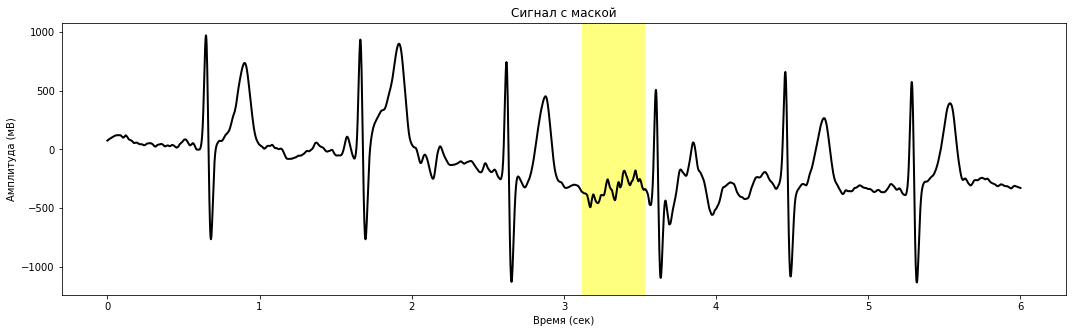

In [6]:
plot_signal_with_mask(X[4][284000:287000], masks[4][284000:287000])

In [7]:
# разделение данных на обучающую и тестовую выборки
def balance(X,masks): #разделение у одного сигнала
    X_balance = []
    masks_balance = []
    index = 0
    r = random.randint(8,12)*500*60
    while len(X) - index >= r:
        X_balance.append(X[index:index + r])
        masks_balance.append(masks[index:index + r])
        index += r
        r = random.randint(8,12)*500*60
    return X_balance, masks_balance

X_balance = []
masks_balance = []
for i in range(len(X)):
    x,y = balance(X[i], masks[i])
    X_balance += x
    masks_balance += y
print("Фрагментов по 8-12 минут: ", len(X_balance))
print("Масок по 8-12 минут: ", len(masks_balance))
print("Длина 25-ого фрагмента: ",len(X_balance[25]))
print("Длина 25-й маски: ",len(masks_balance[25]))
for i in range(len(X_balance)):
    X_balance[i] = np.array(X_balance[i]) * 0.001 
    masks_balance[i] = np.array(masks_balance[i])

Фрагментов по 8-12 минут:  180
Масок по 8-12 минут:  180
Длина 25-ого фрагмента:  240000
Длина 25-й маски:  240000


In [8]:
signals_train, signals_test, masks_train, masks_test = \
    train_test_split(X_balance, masks_balance, random_state=42, shuffle=True)

In [9]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, signals, masks):
        self._signals = signals
        self._masks = masks
        self._sub_len = 500 * 30
        self._sim_len = 500 * 2
        self._probs = [len(s) for s in self._signals]
        self._probs = np.array(self._probs)
        self._probs = self._probs / self._probs.sum()
        self._arange = np.arange(len(self._signals))
        self._sample_probs = []
        for mask in self._masks:
            (unique, counts) = np.unique(mask, return_counts=True)
            self._sample_probs.append(self._get_probs(mask, unique, counts))
        self._sim = []
        
        r = np.zeros(self._sim_len)
        r[:self._sim_len//2] = np.arange(self._sim_len//2)
        r[self._sim_len//2:] = np.arange(self._sim_len - self._sim_len//2)[::-1]
        r = r / np.sum(r)
        matrix = np.array([[1, 0, 0.5], [0, 1, 0.25], [0.5, 0.25, 1]])
        for mask in self._masks:
            self._sim.append(self._get_sim(mask, r, matrix))
    
    
    def _get_probs(self, mask, unique, counts):
        w = {}
        for u, c in zip(unique, counts):
            w[u] = 1 / c
        result = []
        s = 0
        for i in range(self._sub_len):
            s += w[mask[i]]
        result.append(s)
        for i in range(self._sub_len, len(mask)):
            s += w[mask[i]] - w[mask[i - self._sub_len]]
            result.append(s)
        result = np.array(result)
        return result / np.sum(result)
    
    def _get_sim(self, mask, r, matrix):
        result = np.zeros(len(mask))
        for i in range(len(mask) - self._sim_len + 1):
            index = i + self._sim_len//2
            x = mask[index]
            values = matrix[x, mask[i:i+len(r)]]
            result[index] = np.sum(r * values)
        result = 2 * result / (1.2 - result)
        return result

    def __len__(self):
        return 15 * len(self._signals)

    def __getitem__(self, i):
        index = np.random.choice(self._arange, p=self._probs)
        signal = self._signals[index]
        shift = np.random.choice(np.arange(len(self._sample_probs[index])), p=self._sample_probs[index])
        #shift = np.random.randint(0, len(signal) - self._sub_len)
        signal = signal[shift:shift+self._sub_len].reshape(1, -1)
        mask = self._masks[index][shift:shift+self._sub_len]
        sim = self._sim[index][shift:shift+self._sub_len]
        return torch.FloatTensor(signal), torch.LongTensor(mask), torch.LongTensor(sim)

In [10]:
def get_loader(signals, masks, batch_size=4):
    dataset = SegmentationDataset(signals, masks)
    return DataLoader(dataset, batch_size=batch_size)

In [11]:
train_loader = get_loader(signals_train, masks_train)
val_loader = get_loader(signals_test, masks_test)

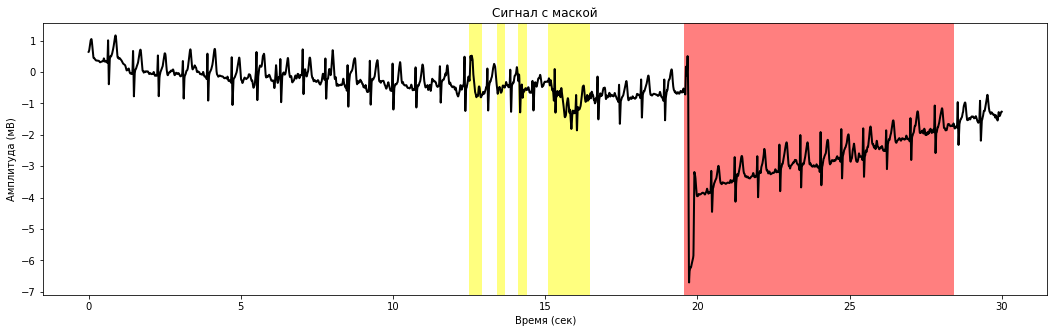

In [158]:
a, b, _ = train_loader.dataset.__getitem__(0)
plot_signal_with_mask(a[0].tolist(), b.numpy())

In [12]:
import torch.nn.functional as F

weights = torch.Tensor([1., 5., 5.])


def get_loss_with_confusion(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    loss = (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()
    
    y_batch = y_batch.data.numpy().reshape(-1)
    logits = logits.data.numpy()
    y_pred = np.argmax(logits, axis=1).reshape(-1)
    return loss, confusion_matrix(y_batch, y_pred, labels=(0, 1, 2))
    

def get_loss(model, X_batch, y_batch, w):
    logits = model(X_batch)
    logits = logits[:, :, 2000:-2000]
    y_batch = y_batch[:, 2000:-2000]
    w = w[:, 2000:-2000]
    return (w * F.cross_entropy(logits, y_batch, weight=weights)).mean()

In [13]:
class Drawer():
    def __init__(self):
        self._train = []
        self._val = []
    
    def add(self, train_loss, val_iou):
        self._train.append(train_loss)
        self._val.append(val_iou)
        
    def plot(self):
        epochs = range(1, 1 + len(self._train))
        plt.figure(figsize=(10, 8))
        plt.title('train/val loss')
        plt.xlabel('Эпоха')
        plt.ylabel('Loss')
        plt.plot(epochs, self._train)
        plt.plot(epochs, self._val)
        plt.legend(["train", "val"])
        plt.show()

In [14]:
import time

def fit(model, train_loader, val_loader, optimizer, loss_function, num_epochs=None):
    train_losses = []
    val_losses = []
    drawer = Drawer()
    min_loss = 1e6
    min_loss_index = 0
    epoch = 0
    
    while num_epochs is None or epoch < num_epochs:
        start_time = time.time()
        model.train()
        for X_batch, y_batch, w in train_loader:
            loss = loss_function(model, X_batch, y_batch, w)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.data.numpy())

        model.eval()
        confusion_all = np.zeros((3, 3))
        for X_batch, y_batch, w in val_loader:
            loss, confusion = get_loss_with_confusion(model, X_batch, y_batch, w)
            confusion_all += confusion
            val_losses.append(loss.data.numpy())
            
        train_loss = np.mean(train_losses[-len(train_loader):])
        val_loss = np.mean(val_losses[-len(val_loader):])
        print(len(train_loader), len(val_loader))
        drawer.add(train_loss, val_loss)
        
        clear_output(True)
        drawer.plot()
        print("Epoch {} took {:.3f}s".format(epoch + 1, time.time() - start_time))
        print("training loss: \t{:.6f}".format(train_loss))
        print("validation loss: \t{:.6f}".format(val_loss))
        print(confusion_all / confusion_all.sum())
        
        if val_loss < min_loss - 1e-5:
            min_loss = val_loss
            min_loss_index = epoch
        elif epoch - min_loss_index >= 10:
            #break
            pass
        
        epoch += 1

In [15]:
class UNetConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetConv, self).__init__()
        self._model = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=9, padding=4),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, X):
        return self._model(X)
    
    
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDown, self).__init__()
        self._model = nn.Sequential(
            nn.MaxPool1d(3),
            UNetConv(in_channels, out_channels)
        )
    
    def forward(self, X):
        return self._model(X)
    

class UNetUp(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels):
        super(UNetUp, self).__init__()
        self._up = nn.ConvTranspose1d(in_channels, in_channels, kernel_size=9, stride=3, padding=3)
        self._model = UNetConv(in_channels + in_channels_skip, out_channels)
    
    def forward(self, X_skip, X):
        X = self._up(X)  
        diff = X_skip.size()[2] - X.size()[2]
        X = F.pad(X, (diff // 2, diff - diff // 2))  
        return self._model(torch.cat([X_skip, X], dim=1))

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        n = 4
        self._input = UNetConv(in_channels, n)
        self._down1 = UNetDown(n, 2*n)
        self._down2 = UNetDown(2*n, 4*n)
        self._down3 = UNetDown(4*n, 8*n)
        self._down4 = UNetDown(8*n, 16*n)
        self._up1 = UNetUp(16*n, 8*n, 8*n)
        self._up2 = UNetUp(8*n, 4*n, 4*n)
        self._up3 = UNetUp(4*n, 2*n, 2*n)
        self._up4 = UNetUp(2*n, n, n)
        self._output = nn.Conv1d(n, num_classes, kernel_size=1)
        
    def forward(self, X):
        x1 = self._input(X)
        x2 = self._down1(x1)
        x3 = self._down2(x2)
        x4 = self._down3(x3)
        x = self._down4(x4)
        x = self._up1(x4, x)
        x = self._up2(x3, x)
        x = self._up3(x2, x)
        x = self._up4(x1, x)
        return self._output(x)

In [17]:
model = UNet(1, 3)
optimizer = torch.optim.Adam(model.parameters())

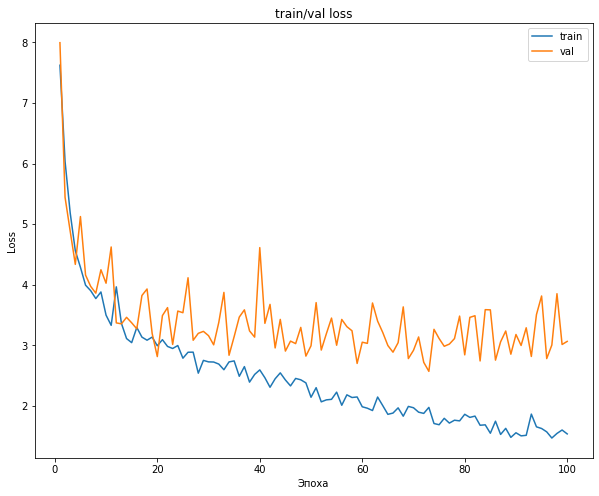

Epoch 100 took 152.958s
training loss: 	1.536591
validation loss: 	3.064023
[[0.725993   0.0132369  0.03913293]
 [0.00141226 0.06716539 0.01499636]
 [0.01835852 0.00660162 0.11310303]]


In [18]:
fit(model, train_loader, val_loader, optimizer, get_loss,100)

In [31]:
torch.save(model.state_dict(), "unet")

In [37]:
torch.jit.save(torch.jit.script(model), "unetjit")

In [84]:
# получение маски по сигналу
def get_mask(signal):
    signal = np.expand_dims(signal, axis=(0, 1))
    signal = torch.FloatTensor(signal)
    mask = model(signal)[0]
    mask = mask.argmax(axis=0)
    return mask.data.numpy()

In [87]:
# confusion matrix на исходных полноценных ЭКГ
def conf_matrix_10_minutes(signal, true_mask):
    conf_matrix = np.zeros((3,3), dtype=np.int32)
    index = 0
    while len(signal) - index >= 300000:
        mask = get_mask(signal[index:index+300000])
        conf_matrix += confusion_matrix(true_mask[index+2500:index+300000-2500], mask[2500:-2500], labels=[0,1,2])
        index += 295000
    mask = get_mask(signal[index:-1])
    conf_matrix += confusion_matrix(true_mask[index:-1][2500:-2500], mask[2500:-2500], labels=[0,1,2])
    return conf_matrix

In [93]:
conf_matrix_10_minutes(np.array(X[1]) / 1000, masks[1])

array([[14174167,     7439,   632704],
       [       5,   469038,      827],
       [  241419,    16351,  1643049]])

In [136]:
def plot_train_sample(index):
    signal = signals_train[index]
    true_mask = masks_train[index]

    mask = get_mask(signal)
    plot_signal_with_mask(signal[148000:150000], mask[148000:150000])
    plot_signal_with_mask(signal[148000:150000], true_mask[148000:150000])
    return mask, true_mask

In [114]:
def plot_test_sample(index):
    signal = signals_test[index]
    true_mask = masks_test[index]

    mask = get_mask(signal)
    plot_signal_with_mask(signal, mask)
    plot_signal_with_mask(signal, true_mask)
    return mask, true_mask

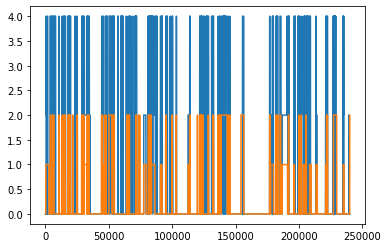

In [141]:
plt.plot(a * 2)
plt.plot(b)

In [ ]:
x = torch.Tensor()
confusion_matrix(masks[0], model(x)[0].argmax(axis=0))